In [1]:
import torch
import os
import sys
sys.path.append('/home/ebutz/ESL2024/code/utils' )
import optuna
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.sampler import NegativeSampling
import torch_geometric.transforms as T
import pickle
import os
import sys
import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from nxontology.imports import from_file
import wandb
from play_with_complex import *
from data_utils import *
from train_utils import *
from model_utils import *
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from torchmetrics.retrieval import RetrievalMRR, RetrievalHitRate
import play_with_complex as pwc
from work_in_graph import *
from usefull_little_functions import *
import numpy as np
import torch

/home/ebutz/miniconda3/envs/pyg2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
epochs = 2

# How to calculate loss ?
# Choices are : 'usual', 'rand_linsim', linsim', 'gaussian_noise', 'usual'.
labels_type = 'usual'

# How many epochs between 2 time-consuming evaluations ?
eval_period = 1

# Wandb
xp_name = 'brouillon'
run_name = f'family train for {labels_type} labels'
print(xp_name,':',run_name)

# Iric
iric_path       = '/home/ebutz/ESL2024/data/full_iric/iric.csv'

# # Ontology
# ontology_path = '/home/ebutz/ESL2024/data/go-basic.json.gz'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f"Device: '{device}'")

brouillon : family train for usual labels
Device: 'cpu'


In [3]:
run = wandb.init(project=xp_name, name = run_name)
config = wandb.config
config.labels_type = labels_type
config.val_ratio=0.1
config.homogeneous=False
config.scorelist_size=1000
config.split_ratio=0.8
config.val_ratio=0.1
config.test_ratio=0.1
config.num_neighbors=[70,55,13,89,85]
config.batch_size=1024
config.train_neg_sampling_ratio=224
config.epochs=epochs
config.disjoint_train_ratio=0.6
config.lr=0.0015308253347932983
config.stopper_metric= 'hit_at_10'
config.stopper_direction="maximize"
config.stopper_patience=5
config.stopper_frequency=1
config.stopper_relative_delta=0.05
config.gamma=1.3
config.alpha=0.42680473078813763
config.gnn_layer='ResGatedGraphConv'
config.dropout=0.1
config.norm='DiffGroupNorm'
config.aggregation = 'min'
config.hidden_channels=115
config.num_layers=3
config.attention_heads=4
config.homogeneous = False
config.labels = {'head' : 'genes', 'relation' : 'gene_ontology', 'tail' : 'go'}

# ------------- Load dataset ------------- #

data = load_iric_data(iric_path, featureless=False)
GO_edge_index = data['go', 'is_a', 'go'].edge_index # Important to extract ontology before making graph undirected
data  = T.ToUndirected(merge=True)(data)            # Convert the graph to an undirected graph. Creates reverse edges for each edge.
data = T.RemoveDuplicatedEdges()(data)              # Remove duplicated edges
# print(data)
print('data look valid : ',data.validate())

# ------------- Split dataset ------------- #

train_data, val_data, test_data = split_data(data, config)
train_loader, val_loader, test_loader = build_dataloaders(train_data, val_data, test_data, config)

# ------------- Loading ontology ------------- #

# nxo = from_file(ontology_path)
# nxo.freeze()
# pwc.nxo = nxo

df = pd.read_csv(iric_path, index_col=0, dtype=str)
df['source_node'] = df.index
df.columns = [x.lower() for x in df.columns]
go_map = get_nodelist(df, 'go')
go_to_idx = {node: i for i, node in enumerate(go_map)}
idx_to_go = {i: node for i, node in enumerate(go_map)}

# ------------- Making global variables accessibles to pwc ------------- #

pwc.map_to_GO        = idx_to_go
pwc.mapped_alt_tails = None
pwc.device           = device

# ------------- Model setup ------------- #

gnn_layers = get_gnn_layers(config)
norm_layers = get_norm_layers(config, len(data.node_types))

model = Model(config, data, norm_layers, gnn_layers).to(device)

# # ------------- Setup graph ------------- #

# G = nx.DiGraph()
# for s, d in zip(GO_edge_index[0].tolist(), GO_edge_index[1].tolist()):
#     G.add_edge(s, d)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: butzelliot (esl2024). Use `wandb login --relogin` to force relogin


/home/ebutz/ESL2024/code/utils/train_utils.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_links['source_node'] = df_links.index


data look valid :  True
Function 'split_data' executed in 0.0617s
Function 'build_dataloaders' executed in 1.2114s


In [4]:
print('Nombre de Noeuds dans GO_edreg_index :', GO_edge_index.unique().size())

Nombre de Noeuds dans GO_edreg_index : torch.Size([42769])


In [5]:
train_data.generate_ids()
n_ids = train_data[config.labels['tail']].n_id
print('Nombre de Noeuds dans n_id :',n_ids.unique().size())
print(n_ids)
print(n_ids.size())
print(n_ids.unique().size())


Nombre de Noeuds dans n_id : torch.Size([42979])
tensor([    0,     1,     2,  ..., 42976, 42977, 42978])
torch.Size([42979])
torch.Size([42979])


In [6]:

print('Nombre de Noeuds dans GO_edge_index :', GO_edge_index.unique().size())

# Génération des n_id :
train_data.generate_ids()
n_ids = train_data[config.labels['tail']].n_id
print('Nombre de Noeuds dans n_id :',n_ids.unique().size())

Nombre de Noeuds dans GO_edge_index : torch.Size([42769])
Nombre de Noeuds dans n_id : torch.Size([42979])


In [54]:
all_n_ids = set(n_ids.unique().tolist())
all_in_GO_edge_index = set (GO_edge_index.unique().tolist())
print(len(all_n_ids - all_in_GO_edge_index))
print(len(all_in_GO_edge_index - all_n_ids))

list(all_in_GO_edge_index- all_n_ids)
list(all_n_ids - all_in_GO_edge_index)
for i in list(all_n_ids - all_in_GO_edge_index):
    print(idx_to_go[i])

# These are all deprecated terms !

210
0
GO:0031359
GO:0031351
GO:0006330
GO:0006990
GO:0009019
GO:0030104
GO:0006588
GO:0019204
GO:0035511
GO:0031938
GO:1900490
GO:0004871
GO:0010941
GO:0055069
GO:0018192
GO:0015491
GO:0048037
GO:0055076
GO:0005779
GO:0031357
GO:0004652
GO:2001020
GO:0016576
GO:0000306
GO:0102486
GO:0006875
GO:0090305
GO:0102488
GO:0006379
GO:0004221
GO:0005623
GO:0006200
GO:0016585
GO:0010940
GO:0102797
GO:0102490
GO:0007568
GO:0042643
GO:0010525
GO:0052033
GO:0018024
GO:0102343
GO:0010252
GO:0010216
GO:0044260
GO:0009305
GO:0005671
GO:0044464
GO:0102552
GO:1901972
GO:1990440
GO:0030696
GO:0042766
GO:0031307
GO:0060968
GO:0045857
GO:0010260
GO:0102798
GO:0030173
GO:0000186
GO:0098519
GO:2000582
GO:0009108
GO:0043486
GO:0005639
GO:0070895
GO:0006733
GO:0016307
GO:0006184
GO:0061408
GO:1903507
GO:0046658
GO:0050155
GO:0015301
GO:0000737
GO:0006073
GO:0030528
GO:0016563
GO:0102487
GO:0043619
GO:0044431
GO:0033577
GO:0052746
GO:0051188
GO:0043620
GO:0003715
GO:0048478
GO:0009348
GO:0007569
GO:0010847
GO:0

In [8]:
42969 in list(all_n_ids - all_in_GO_edge_index)


False

In [9]:
# batchy['go']['dst_neg_index']

In [10]:
# batchy

In [11]:
train_data.generate_ids()
train_data[config.labels['tail']].n_id

tensor([    0,     1,     2,  ..., 42976, 42977, 42978])

In [12]:
train_data[config.labels['tail']].n_id.size()

torch.Size([42979])

In [13]:
GO_edge_index.size()

torch.Size([2, 68218])

In [14]:
src = in_onto = set(GO_edge_index[0].unique().tolist())
dst = in_onto = set(GO_edge_index[1].unique().tolist())
# print(dst-src)
# print(src-dst)

In [15]:
def node_to_embed_id(node_id, node_to_embed_dict):
    try:
        return node_to_embed_dict[node_id]
    except :
        return 8533

In [16]:
# GO_df = pd.DataFrame(GO_edge_index.numpy()[0], columns=['src_node_id'])
# GO_df['dist_node_id'] = GO_edge_index[1].numpy()
# GO_df['src_emb_id'] =GO_df.apply(lambda row : node_to_embed_id(row['src_node_id'], full_node_id_to_emb_id), axis=1)
# GO_df['dist_emb_id']=GO_df.apply(lambda row : node_to_embed_id(row['dist_node_id'], full_node_id_to_emb_id), axis=1)
# display(GO_df.head())
# EMB_GO_edge_index = torch.stack([torch.tensor(list(GO_df['src_emb_id'])), torch.tensor(list(GO_df['dist_emb_id']))])
# EMB_GO_edge_index

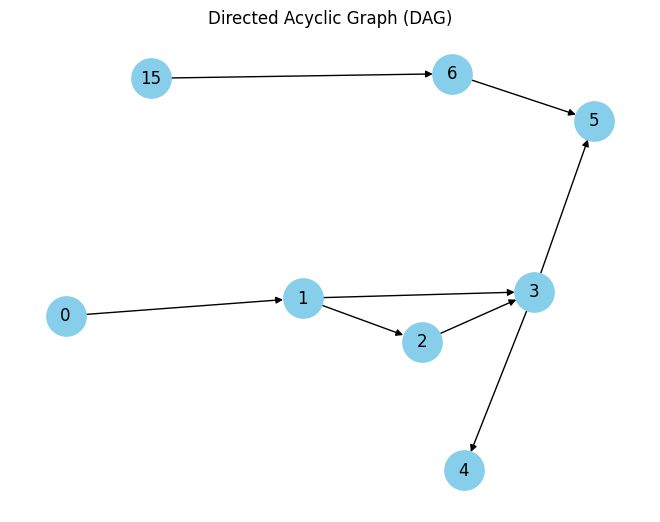

Distance 2/5


Making dist 2-children  : 100%|██████████| 8/8 [00:00<00:00, 4826.59it/s]


Distance 3/5


Making dist 3-children  : 100%|██████████| 8/8 [00:00<00:00, 4899.17it/s]


Distance 4/5


Making dist 4-children  : 100%|██████████| 8/8 [00:00<00:00, 5199.01it/s]


Distance 5/5


Making dist 5-children  : 100%|██████████| 8/8 [00:00<00:00, 5938.84it/s]


5-family acquired.


Calculating exclusion   : 100%|██████████| 8/8 [00:00<00:00, 7681.88it/s]


,source,1-neighbors,2-neighbors,3-neighbors,4-neighbors,5-neighbors,1-children,2-children,3-children,4-children,5-children,1-parents,2-parents,3-parents,4-parents,5-parents,family,parents,family_without_parents,family_without_children
0,{0},{1},"{2, 3}","{4, 5}",{6},{15},{1},"{2, 3}","{3, 4, 5}","{4, 5}",{},{},{},{},{},{},"{1, 2, 3, 4, 5, 6, 15}",{},"{1, 2, 3, 4, 5, 6, 15}","{6, 15}"
1,{1},"{0, 2, 3}","{4, 5}",{6},{15},{},"{2, 3}","{3, 4, 5}","{4, 5}",{},{},{0},{},{},{},{},"{0, 2, 3, 4, 5, 6, 15}",{0},"{2, 3, 4, 5, 6, 15}","{0, 6, 15}"
2,{2},"{1, 3}","{0, 4, 5}",{6},{15},{},{3},"{4, 5}",{},{},{},{1},{0},{},{},{},"{0, 1, 3, 4, 5, 6, 15}","{0, 1}","{3, 4, 5, 6, 15}","{0, 1, 6, 15}"
3,{3},"{1, 2, 4, 5}","{0, 6}",{15},{},{},"{4, 5}",{},{},{},{},"{1, 2}","{0, 1}",{0},{},{},"{0, 1, 2, 4, 5, 6, 15}","{0, 1, 2}","{4, 5, 6, 15}","{0, 1, 2, 6, 15}"
4,{4},{3},"{1, 2, 5}","{0, 6}",{15},{},{},{},{},{},{},{3},"{1, 2}","{0, 1}",{0},{},"{0, 1, 2, 3, 5, 6, 15}","{0, 1, 2, 3}","{5, 6, 15}","{0, 1, 2, 3, 5, 6, 15}"
5,{5},"{3, 6}","{1, 2, 4, 15}",{0},{},{},{},{},{},{},{},"{3, 6}","{1, 2, 15}","{0, 1}",{0},{},"{0, 1, 2, 3, 4, 6, 15}","{0, 1, 2, 3, 6, 15}",{4},"{0, 1, 2, 3, 4, 6, 15}"
6,{6},"{5, 15}",{3},"{1, 2, 4}",{0},{},{5},{},{},{},{},{15},{},{},{},{},"{0, 1, 2, 3, 4, 5, 15}",{15},"{0, 1, 2, 3, 4, 5}","{0, 1, 2, 3, 4, 15}"
7,{15},{6},{5},{3},"{1, 2, 4}",{0},{6},{5},{},{},{},{},{},{},{},{},"{0, 1, 2, 3, 4, 5, 6}",{},"{0, 1, 2, 3, 4, 5, 6}","{0, 1, 2, 3, 4}"


In [17]:
def get_family(ontology_edge_index, max_dist):
    """
    Constructs a family graph up to a certain distance from a given ontology edge index.

    Parameters:
    - ontology_edge_index (torch.Tensor) : Edge index tensor representing the ontology graph.
    - max_dist (int)                     : Maximum distance to traverse to construct the family graph.      

    Returns:
    - df (pandas.DataFrame): DataFrame containing information about the family graph.
                                Columns:
                                    - source                   : The source node of the row.
                                    - {dist}-neighbors         : Set of neighbors at distance 'dist' from the source node.
                                    - {dist}-parents           : Set of parents at distance 'dist' from the source node.
                                    - {dist}-children          : Set of children at distance 'dist' from the source node.
                                    - family                   : Set of all neighbors up to distance 'max_dist' for the source node.
                                    - parents                  : Set of all parents up to distance 'max_dist' for the source node.
                                    - family_without_parents   : Set of family members excluding parents for the source node.
                                    - family_without_children  : Set of family members excluding children for the source node.
    """
    # Init Graph
    G = nx.DiGraph()
    for s, d in zip(ontology_edge_index[0].tolist(), ontology_edge_index[1].tolist()):
        G.add_edge(s, d)

    if not nx.is_directed(G):
        raise Exception("Graph should be directed.")

    # Listing terms
    all_terms =  torch.cat([ontology_edge_index[0], ontology_edge_index[1]]).unique().tolist()
    # print(all_terms)
    df = pd.DataFrame(all_terms, columns=['source'])
    df['source']      = df.apply(lambda row : set([int(row['source'])]), axis = 1)
    df['1-neighbors'] = df.apply(lambda row : neighbors_for_nodes(graph = G, nodes = row['source']), axis=1)
    df['1-parents']   = df.apply(lambda row : predecessors_for_nodes(graph = G, nodes = row['source']), axis=1)
    df['1-children']  = df.apply(lambda row : successors_for_nodes(graph = G, nodes = row['source']), axis=1)

    for dist in range(2, max_dist+1):

        step = f'Distance {dist}/{max_dist}'
        print(step)

        tqdm.pandas(desc=f'Making dist {dist}-neighbors ')
        df[f'{dist}-neighbors'] = df.progress_apply(lambda row : neighbors_for_nodes(graph = G, nodes = row[f'{dist-1}-neighbors'])-set.union(*[row[f'{d}-neighbors'] for d in range(1,dist)])-row['source'],axis = 1)

        tqdm.pandas(desc=f'Making dist {dist}-parents   ')
        df[f'{dist}-parents'] = df.progress_apply(lambda row : predecessors_for_nodes(graph = G, nodes = row[f'{dist-1}-parents']),axis = 1)

        tqdm.pandas(desc=f'Making dist {dist}-children  ')
        df[f'{dist}-children'] = df.progress_apply(lambda row : successors_for_nodes(graph = G, nodes = row[f'{dist-1}-children']),axis = 1)
        
        # display(df)
    
    step = f'{max_dist}-family acquired.'
    print(step)
    tqdm.pandas(desc=f'Calculating family      ')
    df['family'] = df.progress_apply(lambda row: set.union(*[row[f'{dist}-neighbors'] for dist in range(1, max_dist+1)]) - (row['source']), axis = 1)
    
    tqdm.pandas(desc=f'Calculating children    ')
    df['children'] = df.progress_apply(lambda row: set.union(*[row[f'{dist}-children'] for dist in range(1, max_dist+1)]), axis = 1)

    tqdm.pandas(desc=f'Calculating parents     ')
    df['parents'] = df.progress_apply(lambda row: set.union(*[row[f'{dist}-parents'] for dist in range(1, max_dist+1)]), axis = 1)
    
    tqdm.pandas(desc=f'Calculating exclusion   ')
    df['family_without_parents'] = df.progress_apply(lambda row: row['family']- set.union(*[row[f'{dist}-parents'] for dist in range(1, max_dist+1)]), axis = 1)

    tqdm.pandas(desc=f'Calculating exclusion   ')
    df['family_without_children'] = df.progress_apply(lambda row: row['family']- set.union(*[row[f'{dist}-children'] for dist in range(1, max_dist+1)]), axis = 1)


    # tqdm.pandas(desc=f'Calculating lineage          ')
    # df['lineage'] = df.progress_apply(lambda row: set.union(*[row[f'{dist}-children'] for dist in range(1, max_dist+1)]+
    #                                                          [row[f'{dist}-parents'] for dist in range(1, max_dist+1)] +
    #                                                          [row['source']]),axis=1)
    # tqdm.pandas(desc=f'Calculating family - lineage ')
    # df['family_without_lineage'] = df.progress_apply(lambda row: set.union(*[row[f'{dist}-neighbors'] for dist in range(1, max_dist+1)]) - row['lineage'],axis=1)
    # display(df)

    # Re-ordering columns :
    dists = range(1, max_dist+1)
    df = df[['source'] + [f'{dist}-neighbors' for dist in dists]+
                         [f'{dist}-children' for dist in dists] +
                         [f'{dist}-parents' for dist in dists]  + 
                         ['family',
                          'parents', 
                          'family_without_parents', 
                          'family_without_children'
                          ]]
    
    return df

def plot_graph(edge_index):
    G = nx.DiGraph()
    G.add_edges_from(edge_index.t().tolist())

    pos = nx.spring_layout(G, iterations=50, seed = 1)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=800, arrows=True)
    plt.title("Directed Acyclic Graph (DAG)")
    plt.show()

edge_index = torch.tensor([[0, 1, 1, 2, 3, 3, 6, 15],   # Liste des départs des arêtes
                           [1, 2, 3, 3, 4, 5, 5, 6 ]],  # Liste des arrivées des arêtes
                          dtype=torch.long)
plot_graph(edge_index)
f = get_family(edge_index, 5)
display(f)

In [18]:
GO_family_df = get_family(GO_edge_index, 3)

Distance 2/3


Making dist 2-children  : 100%|██████████| 42769/42769 [00:01<00:00, 41693.07it/s]


Distance 3/3


Making dist 3-children  : 100%|██████████| 42769/42769 [00:00<00:00, 59181.17it/s]


3-family acquired.


Calculating exclusion   : 100%|██████████| 42769/42769 [00:05<00:00, 7347.50it/s] 


In [19]:
GO_family_df

,source,1-neighbors,2-neighbors,3-neighbors,1-children,2-children,3-children,1-parents,2-parents,3-parents,family,parents,family_without_parents,family_without_children
0,{0},{7034},"{27138, 33795, 39172, 16132, 775, 25097, 27658...","{21504, 32258, 35335, 22536, 19463, 20999, 230...",{7034},"{41512, 37313}",{33824},{},{},{},"{21504, 27138, 33795, 32258, 35335, 22536, 250...",{},"{21504, 27138, 33795, 32258, 35335, 22536, 250...","{21504, 27138, 33795, 32258, 35335, 22536, 250..."
1,{1},"{18545, 41826, 22116, 5528, 20009, 18716, 11725}","{7044, 10246, 6920, 35914, 1937, 41681, 26387,...","{39429, 11, 23053, 15374, 6670, 28693, 33790, ...",{41826},"{29729, 2663}",{2451},"{18545, 22116, 5528, 20009, 18716, 11725}","{6920, 23724, 5678, 1937, 41681, 26387, 7477, ...","{38801, 17958, 6670}","{39429, 10246, 11, 23053, 15374, 6670, 28693, ...","{22116, 17958, 6920, 20009, 23724, 11725, 5678...","{39429, 10246, 11, 23053, 15374, 28693, 28183,...","{39429, 10246, 11, 23053, 15374, 6670, 28693, ..."
2,{2},{24959},"{39088, 6310}","{12695, 18820, 38663, 26346, 35307, 20751, 722...",{24959},{39088},{18820},{},{},{},"{18820, 6310, 38663, 26346, 35307, 20751, 3908...",{},"{18820, 6310, 38663, 26346, 35307, 20751, 3908...","{12695, 6310, 38663, 26346, 35307, 20751, 7220..."
3,{3},{7947},"{1825, 15429, 40394, 16684, 23790, 27987, 1071...","{30507, 40297, 6795, 8905}",{7947},{23790},{6795},{},{},{},"{1825, 15429, 40297, 40394, 7947, 16684, 30507...",{},"{1825, 15429, 40297, 40394, 7947, 16684, 30507...","{1825, 15429, 40297, 40394, 30507, 16684, 8905..."
4,{4},{37438},"{35542, 40310}","{26244, 7439}",{37438},"{35542, 40310}","{26244, 7439}",{},{},{},"{26244, 7439, 35542, 40310, 37438}",{},"{26244, 35542, 40310, 37438, 7439}",{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42764,{42974},"{40438, 30886, 16088, 25372, 4781}","{8326, 24779, 11437, 37369, 19284, 4857, 30874...","{1537, 2061, 6158, 2062, 15377, 34321, 9747, 2...",{16088},{11437},{21248},"{40438, 25372, 4781, 30886}",{30874},{},"{2061, 6158, 2062, 15377, 22, 38936, 27673, 22...","{40438, 30886, 30874, 25372, 4781}","{2061, 6158, 2062, 15377, 22, 38936, 27673, 22...","{2061, 6158, 2062, 15377, 22, 38936, 27673, 22..."
42765,{42975},{4102},"{11205, 7437, 7442, 37459, 30485, 12311, 7578,...","{41089, 5636, 9861, 40198, 28167, 38919, 29833...",{4102},"{1590, 33150}","{200, 29626, 33294}",{},{},{},"{5636, 4102, 40198, 28167, 38919, 7437, 2317, ...",{},"{5636, 4102, 40198, 28167, 38919, 7437, 2317, ...","{5636, 40198, 28167, 38919, 7437, 2317, 7442, ..."
42766,{42976},"{16456, 32937, 8803, 11620}","{16961, 12874, 5198, 9550, 10255, 36247, 26653...","{10881, 19970, 21378, 12296, 34061, 37646, 402...","{16456, 8803, 11620}","{7712, 36247, 9003, 10255}","{2027, 26038, 36247}",{32937},{},{},"{19970, 12296, 34061, 37646, 10255, 40208, 274...",{32937},"{19970, 12296, 34061, 37646, 10255, 40208, 274...","{19970, 12296, 34061, 37646, 40208, 27414, 770..."
42767,{42977},"{35276, 3062}","{12194, 34629, 6151, 34984, 23369, 39470, 6607...","{3585, 27142, 24583, 27144, 41994, 22028, 1435...","{35276, 3062}","{36273, 12194, 16693, 34984, 23369, 9052, 6607}","{38214, 30952, 393, 34233, 22028, 22476, 31725...",{},{},{},"{3585, 27142, 6151, 24583, 27144, 41994, 22028...",{},"{3585, 27142, 6151, 24583, 27144, 41994, 22028...","{3585, 27142, 6151, 24583, 27144, 41994, 14351..."


In [20]:
l = list(GO_family_df.columns)
l.remove('source')
l

['1-neighbors',
 '2-neighbors',
 '3-neighbors',
 '1-children',
 '2-children',
 '3-children',
 '1-parents',
 '2-parents',
 '3-parents',
 'family',
 'parents',
 'family_without_parents',
 'family_without_children']

In [21]:
def filter_set(s, threshold):
    return {x for x in s if x <= threshold}

cols = list(GO_family_df.columns)
cols.remove('source')

filterded_GO_family_df = GO_family_df[cols].map(lambda cell: filter_set(cell, 42964))
filterded_GO_family_df['source']=GO_family_df['source'].copy()

In [22]:
filterded_GO_family_df.head()

,1-neighbors,2-neighbors,3-neighbors,1-children,2-children,3-children,1-parents,2-parents,3-parents,family,parents,family_without_parents,family_without_children,source
0,{7034},"{27138, 33795, 25097, 27658, 18443, 4623, 3432...","{21504, 32258, 19463, 22536, 35335, 20999, 230...",{7034},"{41512, 37313}",{33824},{},{},{},"{21504, 27138, 33795, 32258, 35335, 22536, 250...",{},"{21504, 27138, 33795, 32258, 35335, 22536, 250...","{21504, 27138, 33795, 32258, 35335, 22536, 250...",{0}
1,"{41826, 22116, 20009, 11725, 18545, 5528, 18716}","{7044, 10246, 6920, 1937, 26387, 7832, 29728, ...","{39429, 11, 23053, 15374, 6670, 28693, 28183, ...",{41826},"{29729, 2663}",{2451},"{22116, 20009, 11725, 18545, 5528, 18716}","{6920, 23724, 5678, 1937, 41681, 26387, 7477, ...","{38801, 17958, 6670}","{39429, 10246, 11, 23053, 15374, 6670, 28693, ...","{22116, 17958, 6920, 20009, 23724, 11725, 5678...","{39429, 10246, 11, 23053, 15374, 28693, 33790,...","{39429, 10246, 11, 23053, 15374, 6670, 28693, ...",{1}
2,{24959},"{39088, 6310}","{18820, 38663, 26346, 35307, 20751, 7220, 2671...",{24959},{39088},{18820},{},{},{},"{12695, 18820, 6310, 38663, 26346, 35307, 2075...",{},"{12695, 18820, 6310, 38663, 26346, 35307, 2075...","{6310, 38663, 26346, 35307, 20751, 7220, 26711...",{2}
3,{7947},"{1825, 15429, 40394, 16684, 23790, 27987, 1071...","{40297, 30507, 6795, 8905}",{7947},{23790},{6795},{},{},{},"{1825, 15429, 40297, 40394, 7947, 16684, 30507...",{},"{1825, 15429, 40297, 40394, 7947, 16684, 30507...","{1825, 15429, 40297, 40394, 30507, 16684, 8905...",{3}
4,{37438},"{40310, 35542}","{26244, 7439}",{37438},"{40310, 35542}","{26244, 7439}",{},{},{},"{26244, 7439, 40310, 35542, 37438}",{},"{26244, 7439, 40310, 35542, 37438}",{},{4}


In [23]:
int(torch.Tensor([1]).item())

1

In [24]:
def correct_numel(l, num_el, default_elements : list, source = None):

    '''
    Correct the number of elements in a list by adjusting its length.

    If the length of `l` matches `num_el`, the function returns `l` unchanged.
    If `l` is longer than `num_el`, it returns a sublist containing the first `num_el` elements.
    If `l` is shorter than `num_el`, it randomly selects elements from `l` to append to the end until the desired length is reached.
    If `l` is empty, it randomly selects elements from `default_elements` to create a list with `num_el` elements.

    Parameters:
        l (list)             : The input list.
        num_el (int)         : The desired number of elements in the list.
        default_elements (list): A list of elements to be used when `l` is empty.

    Returns:
        list: A list with the corrected number of elements.
    '''

    random.shuffle(l)
    if len(l)==0:
        if source is not None :
            print(source)
        print(f"No family negatives disponible - \nprobably looking for root's children or depraceted terms\n. Using random src terms as negatives.")
        l = random.choices(default_elements, k = num_el)

    elif len(l) == num_el:
        l = l
    elif len(l) > num_el:
        l = l[:num_el]  
    elif len(l) < num_el:
        l += random.choices(default_elements, k=num_el - len(l))
    
    return l


def make_family_negatives(family_df, neg_group_col: str, num_neg_per_pos, source_col = 'source'):
    '''
    Generates negative examples for each positive example in a DataFrame.

    For each positive example in the DataFrame `family_df`, it creates negative examples by adjusting the number of elements in the specified column `neg_group_col`.

    Parameters:
        family_df (DataFrame): The input DataFrame containing positive examples.
        neg_group_col (str) : The column name representing groups of elements.
        num_neg_per_pos (int) : The desired number of negative examples per positive example.

    Returns:
        DataFrame: A DataFrame with negative examples generated for each positive example.
    '''
    if neg_group_col not in family_df.columns:
        raise KeyError(f'{neg_group_col} not in {list(family_df.columns)}')
    
    default_elements = list(family_df[neg_group_col].explode())
    
    tqdm.pandas(desc=f'Making family negatives')
    family_negs = family_df.progress_apply(lambda row : torch.Tensor(correct_numel(list(row[neg_group_col]),
                                                                                   num_el = num_neg_per_pos,
                                                                                   default_elements=default_elements,
                                                                                   source = row[source_col])), axis = 1)

    return family_negs

def make_source_family_neg_dict(input_df, source_col = 'source', neg_col = 'family', num_neg_per_pos=224):
    '''
    Generates a dictionary with negative examples for each positive example based on a source column in an input DataFrame.

    Creates a dictionary where each key is a positive example from the source column, and each value is a 
    list of negative examples generated from the corresponding positive example.

    Parameters:
        input_df (DataFrame): The input DataFrame containing positive and negative examples.
        source_col (str): The column name representing the source of positive examples.
        neg_col (str): The column name representing groups of elements.
        num_neg_per_pos (int): The desired number of negative examples per positive example.

    Returns:
        dict: A dictionary mapping positive examples to lists of negative examples.
    '''

    df = input_df[[source_col, neg_col]].copy()
    
    if not isinstance(df[source_col][0], np.int64):
        tqdm.pandas(desc=f'Correcting {source_col} type ')
        df[source_col]     = df.progress_apply(lambda row: int(torch.Tensor(list(row[source_col])).item()), axis = 1)

            
    if not isinstance(df[neg_col][0], torch.Tensor):
        tqdm.pandas(desc=f'Correcting {neg_col} type ')
        df[neg_col]     = df.progress_apply(lambda row: torch.Tensor(list(row[neg_col])), axis = 1)
    
    print('Making family negatives... Should last a few minutes')
    df['numeled_neg_col'] = make_family_negatives(df, neg_col, num_neg_per_pos)

    return df.set_index(source_col)['numeled_neg_col'].to_dict()

display(f)
example = make_source_family_neg_dict(input_df=f, source_col='source', neg_col='family_without_children', num_neg_per_pos=5)
filtered_f = f.map(lambda cell: filter_set(cell, 5))
display(filtered_f)
filtered_example = make_source_family_neg_dict(input_df=f, source_col='source', neg_col='family_without_children', num_neg_per_pos=5)
filtered_example

,source,1-neighbors,2-neighbors,3-neighbors,4-neighbors,5-neighbors,1-children,2-children,3-children,4-children,5-children,1-parents,2-parents,3-parents,4-parents,5-parents,family,parents,family_without_parents,family_without_children
0,{0},{1},"{2, 3}","{4, 5}",{6},{15},{1},"{2, 3}","{3, 4, 5}","{4, 5}",{},{},{},{},{},{},"{1, 2, 3, 4, 5, 6, 15}",{},"{1, 2, 3, 4, 5, 6, 15}","{6, 15}"
1,{1},"{0, 2, 3}","{4, 5}",{6},{15},{},"{2, 3}","{3, 4, 5}","{4, 5}",{},{},{0},{},{},{},{},"{0, 2, 3, 4, 5, 6, 15}",{0},"{2, 3, 4, 5, 6, 15}","{0, 6, 15}"
2,{2},"{1, 3}","{0, 4, 5}",{6},{15},{},{3},"{4, 5}",{},{},{},{1},{0},{},{},{},"{0, 1, 3, 4, 5, 6, 15}","{0, 1}","{3, 4, 5, 6, 15}","{0, 1, 6, 15}"
3,{3},"{1, 2, 4, 5}","{0, 6}",{15},{},{},"{4, 5}",{},{},{},{},"{1, 2}","{0, 1}",{0},{},{},"{0, 1, 2, 4, 5, 6, 15}","{0, 1, 2}","{4, 5, 6, 15}","{0, 1, 2, 6, 15}"
4,{4},{3},"{1, 2, 5}","{0, 6}",{15},{},{},{},{},{},{},{3},"{1, 2}","{0, 1}",{0},{},"{0, 1, 2, 3, 5, 6, 15}","{0, 1, 2, 3}","{5, 6, 15}","{0, 1, 2, 3, 5, 6, 15}"
5,{5},"{3, 6}","{1, 2, 4, 15}",{0},{},{},{},{},{},{},{},"{3, 6}","{1, 2, 15}","{0, 1}",{0},{},"{0, 1, 2, 3, 4, 6, 15}","{0, 1, 2, 3, 6, 15}",{4},"{0, 1, 2, 3, 4, 6, 15}"
6,{6},"{5, 15}",{3},"{1, 2, 4}",{0},{},{5},{},{},{},{},{15},{},{},{},{},"{0, 1, 2, 3, 4, 5, 15}",{15},"{0, 1, 2, 3, 4, 5}","{0, 1, 2, 3, 4, 15}"
7,{15},{6},{5},{3},"{1, 2, 4}",{0},{6},{5},{},{},{},{},{},{},{},{},"{0, 1, 2, 3, 4, 5, 6}",{},"{0, 1, 2, 3, 4, 5, 6}","{0, 1, 2, 3, 4}"


Correcting family_without_children type : 100%|██████████| 8/8 [00:00<00:00, 3347.41it/s]


Making family negatives... Should last a few minutes


Making family negatives: 100%|██████████| 8/8 [00:00<00:00, 2295.42it/s]


,source,1-neighbors,2-neighbors,3-neighbors,4-neighbors,5-neighbors,1-children,2-children,3-children,4-children,5-children,1-parents,2-parents,3-parents,4-parents,5-parents,family,parents,family_without_parents,family_without_children
0,{0},{1},"{2, 3}","{4, 5}",{},{},{1},"{2, 3}","{3, 4, 5}","{4, 5}",{},{},{},{},{},{},"{1, 2, 3, 4, 5}",{},"{1, 2, 3, 4, 5}",{}
1,{1},"{0, 2, 3}","{4, 5}",{},{},{},"{2, 3}","{3, 4, 5}","{4, 5}",{},{},{0},{},{},{},{},"{0, 2, 3, 4, 5}",{0},"{2, 3, 4, 5}",{0}
2,{2},"{1, 3}","{0, 4, 5}",{},{},{},{3},"{4, 5}",{},{},{},{1},{0},{},{},{},"{0, 1, 3, 4, 5}","{0, 1}","{3, 4, 5}","{0, 1}"
3,{3},"{1, 2, 4, 5}",{0},{},{},{},"{4, 5}",{},{},{},{},"{1, 2}","{0, 1}",{0},{},{},"{0, 1, 2, 4, 5}","{0, 1, 2}","{4, 5}","{0, 1, 2}"
4,{4},{3},"{1, 2, 5}",{0},{},{},{},{},{},{},{},{3},"{1, 2}","{0, 1}",{0},{},"{0, 1, 2, 3, 5}","{0, 1, 2, 3}",{5},"{0, 1, 2, 3, 5}"
5,{5},{3},"{1, 2, 4}",{0},{},{},{},{},{},{},{},{3},"{1, 2}","{0, 1}",{0},{},"{0, 1, 2, 3, 4}","{0, 1, 2, 3}",{4},"{0, 1, 2, 3, 4}"
6,{},{5},{3},"{1, 2, 4}",{0},{},{5},{},{},{},{},{},{},{},{},{},"{0, 1, 2, 3, 4, 5}",{},"{0, 1, 2, 3, 4, 5}","{0, 1, 2, 3, 4}"
7,{},{},{5},{3},"{1, 2, 4}",{0},{},{5},{},{},{},{},{},{},{},{},"{0, 1, 2, 3, 4, 5}",{},"{0, 1, 2, 3, 4, 5}","{0, 1, 2, 3, 4}"


Correcting family_without_children type : 100%|██████████| 8/8 [00:00<00:00, 6537.00it/s]


Making family negatives... Should last a few minutes


Making family negatives: 100%|██████████| 8/8 [00:00<00:00, 4879.23it/s]


{0: tensor([15.,  6.,  3., 15.,  1.]),
 1: tensor([ 0.,  6., 15.,  3.,  1.]),
 2: tensor([ 0.,  6.,  1., 15., 15.]),
 3: tensor([ 1.,  6., 15.,  0.,  2.]),
 4: tensor([0., 3., 6., 5., 2.]),
 5: tensor([ 1.,  6.,  0., 15.,  2.]),
 6: tensor([15.,  0.,  1.,  2.,  4.]),
 15: tensor([0., 4., 1., 2., 3.])}

In [25]:
source_family_neg_dict = make_source_family_neg_dict(input_df=filterded_GO_family_df, source_col='source', neg_col='family_without_children', num_neg_per_pos=224)

Correcting family_without_children type : 100%|██████████| 42769/42769 [00:04<00:00, 9605.17it/s] 


Making family negatives... Should last a few minutes


Making family negatives:   0%|          | 0/42769 [00:00<?, ?it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:   0%|          | 148/42769 [00:05<16:40, 42.58it/s] 

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:   1%|▏         | 555/42769 [00:06<02:28, 283.40it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.
No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:   2%|▏         | 968/42769 [00:07<01:46, 393.51it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:   3%|▎         | 1172/42769 [00:08<01:48, 383.43it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:   4%|▎         | 1526/42769 [00:09<01:27, 471.13it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:   8%|▊         | 3472/42769 [00:14<01:35, 411.85it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.
No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.
No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  10%|█         | 4469/42769 [00:17<01:41, 377.40it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  12%|█▏        | 5162/42769 [00:19<01:07, 554.72it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  14%|█▍        | 6145/42769 [00:20<00:53, 690.91it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  15%|█▌        | 6497/42769 [00:21<00:54, 662.66it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  17%|█▋        | 7198/42769 [00:23<01:15, 468.67it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  17%|█▋        | 7265/42769 [00:23<01:13, 485.79it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  19%|█▊        | 7963/42769 [00:25<01:07, 518.79it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  22%|██▏       | 9467/42769 [00:30<01:26, 386.65it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  27%|██▋       | 11671/42769 [00:37<01:31, 340.01it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  27%|██▋       | 11743/42769 [00:37<01:14, 418.50it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  29%|██▉       | 12514/42769 [00:40<02:08, 234.55it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  30%|██▉       | 12796/42769 [00:40<01:04, 462.12it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  32%|███▏      | 13754/42769 [00:43<01:04, 446.54it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  34%|███▍      | 14531/42769 [00:45<00:57, 489.00it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  37%|███▋      | 15624/42769 [00:49<01:05, 411.39it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  37%|███▋      | 15994/42769 [00:50<01:51, 239.96it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  38%|███▊      | 16046/42769 [00:50<01:40, 265.14it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  39%|███▊      | 16496/42769 [00:51<00:48, 536.33it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  39%|███▉      | 16747/42769 [00:52<01:03, 409.61it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  43%|████▎     | 18406/42769 [00:57<00:49, 492.48it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  47%|████▋     | 20028/42769 [01:02<00:44, 515.73it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  47%|████▋     | 20303/42769 [01:02<00:39, 563.31it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.
No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  49%|████▉     | 21026/42769 [01:04<00:51, 421.84it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  49%|████▉     | 21166/42769 [01:05<00:58, 367.20it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  51%|█████     | 21599/42769 [01:06<00:43, 490.62it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  52%|█████▏    | 22423/42769 [01:09<00:45, 448.94it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.
No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.
No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  53%|█████▎    | 22770/42769 [01:10<00:43, 456.43it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  55%|█████▍    | 23465/42769 [01:12<00:37, 519.39it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  57%|█████▋    | 24462/42769 [01:14<00:35, 522.83it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  58%|█████▊    | 24750/42769 [01:15<00:40, 448.29it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  62%|██████▏   | 26630/42769 [01:21<00:37, 431.88it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  63%|██████▎   | 26989/42769 [01:22<00:36, 437.40it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  66%|██████▌   | 28049/42769 [01:25<00:29, 492.83it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  66%|██████▋   | 28405/42769 [01:26<00:28, 504.64it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  69%|██████▉   | 29561/42769 [01:29<00:25, 520.29it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  70%|██████▉   | 29854/42769 [01:30<00:31, 415.37it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.
No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  77%|███████▋  | 32776/42769 [01:37<00:17, 578.21it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  77%|███████▋  | 33117/42769 [01:38<00:19, 489.82it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  78%|███████▊  | 33439/42769 [01:39<00:18, 514.36it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  80%|███████▉  | 34046/42769 [01:41<00:20, 425.51it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  82%|████████▏ | 35130/42769 [01:44<00:15, 493.47it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  85%|████████▍ | 36210/42769 [01:47<00:13, 501.10it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  86%|████████▌ | 36576/42769 [01:48<00:15, 404.28it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  86%|████████▋ | 36916/42769 [01:49<00:11, 510.54it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  88%|████████▊ | 37599/42769 [01:51<00:10, 511.07it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  91%|█████████ | 38965/42769 [01:55<00:07, 503.63it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  92%|█████████▏| 39321/42769 [01:56<00:06, 494.53it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  93%|█████████▎| 39668/42769 [01:57<00:07, 421.46it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  96%|█████████▌| 40947/42769 [02:00<00:04, 425.09it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  97%|█████████▋| 41545/42769 [02:02<00:03, 402.56it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives:  99%|█████████▉| 42249/42769 [02:04<00:01, 404.31it/s]

No family negatives disponible - 
probably looking for root's children or depraceted terms
. Using random src terms as negatives.


Making family negatives: 100%|██████████| 42769/42769 [02:11<00:00, 325.14it/s]


In [41]:
for k in tqdm(source_family_neg_dict.keys()):
    if 224 != source_family_neg_dict[k].size()[0]:
        print(k)

100%|██████████| 42769/42769 [00:00<00:00, 687169.13it/s]


In [44]:
batchy['go']['dst_neg_index'].unique().size()

torch.Size([42793])

In [48]:
diff = set(batchy['go']['dst_neg_index'].unique().tolist()) - set(GO_edge_index.unique().tolist())

In [49]:
len(diff)

210

In [53]:
for i in diff:
    print(idx_to_go[i])

# These are deprecated GO terms !!!
# Deprecated terms are not in edge index and thus not in source_family_neg_dict.

GO:0031359
GO:0031351
GO:0006330
GO:0006990
GO:0009019
GO:0030104
GO:0006588
GO:0019204
GO:0035511
GO:0031938
GO:1900490
GO:0004871
GO:0010941
GO:0055069
GO:0018192
GO:0015491
GO:0048037
GO:0055076
GO:0005779
GO:0031357
GO:0004652
GO:2001020
GO:0016576
GO:0000306
GO:0102486
GO:0006875
GO:0090305
GO:0102488
GO:0006379
GO:0004221
GO:0005623
GO:0006200
GO:0016585
GO:0010940
GO:0102797
GO:0102490
GO:0007568
GO:0042643
GO:0010525
GO:0052033
GO:0018024
GO:0102343
GO:0010252
GO:0010216
GO:0044260
GO:0009305
GO:0005671
GO:0044464
GO:0102552
GO:1901972
GO:1990440
GO:0030696
GO:0042766
GO:0031307
GO:0060968
GO:0045857
GO:0010260
GO:0102798
GO:0030173
GO:0000186
GO:0098519
GO:2000582
GO:0009108
GO:0043486
GO:0005639
GO:0070895
GO:0006733
GO:0016307
GO:0006184
GO:0061408
GO:1903507
GO:0046658
GO:0050155
GO:0015301
GO:0000737
GO:0006073
GO:0030528
GO:0016563
GO:0102487
GO:0043619
GO:0044431
GO:0033577
GO:0052746
GO:0051188
GO:0043620
GO:0003715
GO:0048478
GO:0009348
GO:0007569
GO:0010847
GO:0097573

torch.Size([1024, 224])

In [27]:
# df3 = get_family(GO_edge_index, max_dist = 3)
# df3.head()

In [ ]:
batch

In [28]:
'''il faut modifier batchy['go']['dst_neg_index']'''
batchy = next(iter(train_loader))
batchy['go']['dst_neg_index']

tensor([[30216, 28465, 39027,  ...,  3669, 42383, 35430],
        [33431, 12311,  6202,  ..., 38014,  2084, 39752],
        [12521, 18979, 37378,  ...,  4920, 34142, 34856],
        ...,
        [13191, 21645, 29896,  ...,  4781, 10992, 12529],
        [12833, 40396, 30481,  ...,  6186, 28599,  2479],
        [39509, 16951, 25960,  ..., 25806, 22557, 17300]])

In [29]:
# batchy['go']['dst_neg_index'].size()

In [30]:
# source_family_neg_dict = make_source_family_neg_dict(input_df=df3, source_col='source', neg_col='family_without_parents', num_neg_per_pos=batchy['go']['dst_neg_index'].size()[1])

In [31]:
# print(batchy['go']['dst_neg_index'].size())
# print(batchy['go']['dst_pos_index'].size())

In [32]:
source_family_neg_dict[0].size()

torch.Size([224])

In [33]:
for k in source_family_neg_dict.keys():
    source_family_neg_dict[k]

SyntaxError: invalid syntax (3310570541.py, line 2)

In [ ]:
def try_to_associate_family_neg(id, family_neg_dict, alt_values_list, num_neg):

    try :

        return family_neg_dict[id]
    except :
        print(f'{id} not found in dict, using random original terms for negatives.\n Probably a node that is not connected in GO because deprecated')
        return torch.tensor(random.choices(alt_values_list, k = num_neg))
    

def make_family_neg_for_batch(batch, family_neg_dict):
    
    num_neg = batch['go']['dst_neg_index'].size()[1]
    alt_values = list(set(batch['go']['dst_neg_index'].unique().tolist()) - set(list(range(42960,42999))))

    pos = batch['go']['dst_pos_index'].numpy()
    df = pd.DataFrame(pos, columns=['pos'])

    df['family_neg'] = df.apply(lambda row : try_to_associate_family_neg(id              =  row['pos'],
                                                                         family_neg_dict = family_neg_dict,
                                                                         num_neg         = num_neg,
                                                                         alt_values_list = alt_values),
                                            axis =1)
    

    return torch.stack(df['family_neg'].to_list()).type(dtype=torch.LongTensor)

        
    

batchy_family_neg = make_family_neg_for_batch(batchy, source_family_neg_dict)
print('Generated negs :',batchy_family_neg.size(), batchy_family_neg.dtype)
print('Original negs  :',batchy['go']['dst_neg_index'].size(), batchy_family_neg.dtype)

783 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
783 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
783 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
783 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
783 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
37971 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
783 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
783 not found in dict, using random original terms for negatives.
 Probably a node that 

In [35]:
for k in tqdm(source_family_neg_dict.keys()):
    for i in source_family_neg_dict[k]:
        if i<0 :
            print(i)
        elif i >42965:
            print(i)

  0%|          | 0/42769 [00:00<?, ?it/s]

100%|██████████| 42769/42769 [04:02<00:00, 176.08it/s]


In [36]:
# ----------------- Loops ----------------- #
@timer_func
def evaluate(config, loader, model, criterion, compute_all_metrics=False, loader_type='validation', stopper_metric=False):
    """
    Evaluate the model on a given data loader.

    Parameters
    ----------
    config : object
        An object containing the configuration parameters for the model.    
    loader : DataLoader
        The data loader to evaluate the model on.
    model : Model
        The model to evaluate.
    criterion : callable
        The loss function to use for evaluation.
    compute_all_metrics : bool, optional
        Whether to compute all metrics or partially. Default is False.
    loader_type : str, optional
        The type of the loader ('validation' or 'test'). Default is 'validation'.
    stopper_metric : str or bool, optional
        The metric that dictates when to stop training. If False, only the loss is computed. Default is False.

    Returns
    -------
    tuple
        A tuple of the evaluation metric and the loss, depending on the value of `stopper_metric`.
        If compute_all_metrics is True, the function logs all metrics to W&B.
    """

    print("Evaluation...")
    model.eval()
    num_neg_samples = loader.neg_sampling.amount
    with torch.no_grad():
        if stopper_metric or compute_all_metrics:
            ground_truths = torch.tensor([], device='cpu')
            preds = torch.tensor([], device='cpu')
            indexes = torch.tensor([], device='cpu')
            total_loss, total_examples = 0, 0
            index_end = loader.batch_size

        for sampled_data in loader:
            sampled_data = sampled_data.to(device)

            batch_size = len(sampled_data[config.labels['tail']].dst_pos_index)
            pred = model(sampled_data, config)
            pos_samples = torch.ones(batch_size, device=device)
            neg_samples = torch.zeros(num_neg_samples*batch_size, device=device)
            ground_truth = torch.cat((pos_samples, neg_samples))

            if stopper_metric or compute_all_metrics: # Store preds and truths for all batches, and compute indices to calc metrics
                index_pos = torch.arange(end=index_end, start=index_end-batch_size) # index for predictions with pos. ground_truth
                index_neg = torch.arange(end=index_end, start=index_end-batch_size).repeat_interleave(num_neg_samples)
                index = torch.cat((index_pos, index_neg))
                indexes = torch.cat((indexes, index.to('cpu')))
                preds = torch.cat((preds, pred.to('cpu')))
                ground_truths = torch.cat((ground_truths, ground_truth.to('cpu')))
                index_end += batch_size

            eval_loss = criterion(pred, ground_truth, gamma=config.gamma, alpha=config.alpha)

            # if not stopper_metric: # Just logging loss
            #     wandb.log({"running_val_loss": eval_loss})
            #     break
            # else:
            total_loss += float(eval_loss) * pred.numel() 
            total_examples += pred.numel()
            eval_loss = total_loss / total_examples

            # if stopper_metric and not compute_all_metrics:
            #     if index_end >= 2048: # Compute approx. intermediate metric on a few datapoints to speed up hyperopt process
            #         break 


        model.train()

        if stopper_metric and not compute_all_metrics: # Compute only the metric that dictates stopping
            indexes = indexes.long()

            # # Log heatmap between prediction and ground truth. Useful for visualization / debugging. overhead 0.2s per epoch for a single sample.
            # heatmap = heatmaps(preds, ground_truths, indexes) 
            # wandb.log({f"heatmap": wandb.Image(heatmap)})
            # heatmap.close() # Free up memory

            match stopper_metric:
                case "val_loss":
                    eval_loss = total_loss / total_examples
                    return eval_loss
                
                case "mrr":
                    mrr = RetrievalMRR().to(device)
                    return mrr(preds, ground_truths, indexes=indexes), eval_loss
                
                case "hit_at_10":
                    hit_at_10 = RetrievalHitRate(top_k=10).to(device)
                    return hit_at_10(preds, ground_truths, indexes=indexes), eval_loss
                
                case "hit_at_5":
                    hit_at_5 = RetrievalHitRate(top_k=5).to(device)
                    return hit_at_5(preds, ground_truths, indexes=indexes), eval_loss
                
                case "hit_at_3":
                    hit_at_3 = RetrievalHitRate(top_k=3).to(device)
                    return hit_at_3(preds, ground_truths, indexes=indexes), eval_loss
                
                case "hit_at_1":
                    hit_at_1 = RetrievalHitRate(top_k=1).to(device)
                    return hit_at_1(preds, ground_truths, indexes=indexes), eval_loss
                
                case _:
                    raise ValueError(f"Unrecognized stopper metric: '{stopper_metric}'")
                
        if compute_all_metrics: # Compute all metrics at the end of training
            indexes = indexes.long()
            mrr = RetrievalMRR().to(device)
            hit_at_10 = RetrievalHitRate(top_k=10).to(device)
            hit_at_5 = RetrievalHitRate(top_k=5).to(device)
            hit_at_3 = RetrievalHitRate(top_k=3).to(device)
            hit_at_1 = RetrievalHitRate(top_k=1).to(device)
            
            mrr = mrr(preds, ground_truths, indexes=indexes)
            hit_at_10 = hit_at_10(preds, ground_truths, indexes=indexes)
            hit_at_5 = hit_at_5(preds, ground_truths, indexes=indexes)
            hit_at_3 = hit_at_3(preds, ground_truths, indexes=indexes)
            hit_at_1 = hit_at_1(preds, ground_truths, indexes=indexes)

            wandb.log({
                f"{loader_type}MRR": mrr, f"{loader_type}hit_at_10": hit_at_10, f"{loader_type}hit_at_5": hit_at_5, f"{loader_type}hit_at_3": hit_at_3, f"{loader_type}hit_at_1": hit_at_1
            })

    return mrr, eval_loss

@timer_func
def train(config, train_loader, val_loader, model, criterion, optimizer, early_stopper, labels_type = 'usual', eval_period = 0):
    for epoch in range(config.epochs):
        total_loss = total_examples = 0

        for sampled_data in tqdm(train_loader, desc="Training"):

            sampled_data = sampled_data.to(device)
            pred = model(sampled_data, config)
            pos_samples  = torch.ones(len(sampled_data[config.labels['tail']].dst_pos_index), device=device)
            neg_samples  = torch.zeros(len(sampled_data[config.labels['tail']].dst_neg_index.view(-1)), device=device) # As many zeroes as there are negative samples * batch_size
            ground_truth = torch.cat((pos_samples, neg_samples))

            false_tails = sampled_data[config.labels['tail']].dst_neg_index.view(-1)
            true_tails = sampled_data['go']['dst_pos_index']
            true_tails = torch.repeat_interleave(true_tails,int(false_tails.size()[0]/true_tails.size()[0]))


            if labels_type == 'linsim':
                
                lin_neg_samples = pwc.lin_sims_for_batch(true_tails, false_tails)

                pos_samples = pos_samples.to(device)
                lin_neg_samples = lin_neg_samples.to(device)

                lin_ground_truth = torch.cat((pos_samples, lin_neg_samples))
                loss = criterion(pred, lin_ground_truth, gamma=config.gamma, alpha=config.alpha)

            if labels_type == 'rand_linsim':

                linsims = pwc.lin_sims_for_batch(true_tails, false_tails)
                lin_neg_samples = pwc.shuffle_tensor(linsims)
                lin_neg_samples.to(device)
                
                lin_ground_truth = torch.cat((pos_samples, lin_neg_samples))
                loss = criterion(pred, lin_ground_truth, gamma=config.gamma, alpha=config.alpha)

            if labels_type == 'gaussian_noise':
                # Add gaussian noise to pos_samples to simulate noisy labels. Added noise must be negative and not exceed 1.
                ground_truth += torch.normal(mean=0, std=1, size=(len(ground_truth),), device=device)
                # apply sigmoid
                ground_truth = torch.sigmoid(ground_truth)
                loss = criterion(pred, ground_truth, gamma=config.gamma, alpha=config.alpha)

            if labels_type == 'usual':
                ground_truth = torch.sigmoid(ground_truth)
                loss = criterion(pred, ground_truth, gamma=config.gamma, alpha=config.alpha)

            wandb.log({"loss": loss})
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += float(loss) * pred.numel()
            total_examples += pred.numel()
        train_loss = total_loss / total_examples
        print(f"Epoch: {epoch:03d}, Avg. Loss: {train_loss:.10f}")


        # scheduler.step()
        if eval_period:
            if epoch%eval_period == 0:
                # Compute metrics and check for early stopping
                score, val_loss = evaluate(config, val_loader, model, criterion, stopper_metric=config.stopper_metric, compute_all_metrics= True)
                wandb.log({"avg_loss": train_loss, "val_loss": val_loss, f"{config.stopper_metric}": score})

        # early_stopper(score)
        # if early_stopper.early_stop:
        #     print("Early stopping triggered at epoch", epoch)
        #     break

    print("Training done.")

    return model

def train_with_family(family_neg_dict, config, train_loader, val_loader, model, criterion, optimizer, early_stopper, labels_type = 'usual', eval_period = 0):
    
    for epoch in range(config.epochs):
        total_loss = total_examples = 0
        i  = 0
        for sampled_data in tqdm(train_loader, desc="Training"):

            sampled_data_family_neg = make_family_neg_for_batch(sampled_data, family_neg_dict)
            print(sampled_data_family_neg)
            sampled_data['go']['dst_neg_index'] = sampled_data_family_neg
            sampled_data = sampled_data.to(device)


            
            pred = model(sampled_data, config)
            pos_samples  = torch.ones(len(sampled_data[config.labels['tail']].dst_pos_index), device=device)
            neg_samples  = torch.zeros(len(sampled_data[config.labels['tail']].dst_neg_index.view(-1)), device=device) # As many zeroes as there are negative samples * batch_size
            ground_truth = torch.cat((pos_samples, neg_samples))

            false_tails = sampled_data[config.labels['tail']].dst_neg_index.view(-1)
            true_tails = sampled_data['go']['dst_pos_index']
            true_tails = torch.repeat_interleave(true_tails,int(false_tails.size()[0]/true_tails.size()[0]))


            if labels_type == 'linsim':
                
                lin_neg_samples = pwc.lin_sims_for_batch(true_tails, false_tails)

                pos_samples = pos_samples.to(device)
                lin_neg_samples = lin_neg_samples.to(device)

                lin_ground_truth = torch.cat((pos_samples, lin_neg_samples))
                loss = criterion(pred, lin_ground_truth, gamma=config.gamma, alpha=config.alpha)

            if labels_type == 'rand_linsim':

                linsims = pwc.lin_sims_for_batch(true_tails, false_tails)
                lin_neg_samples = pwc.shuffle_tensor(linsims)
                lin_neg_samples.to(device)
                
                lin_ground_truth = torch.cat((pos_samples, lin_neg_samples))
                loss = criterion(pred, lin_ground_truth, gamma=config.gamma, alpha=config.alpha)

            if labels_type == 'gaussian_noise':
                # Add gaussian noise to pos_samples to simulate noisy labels. Added noise must be negative and not exceed 1.
                ground_truth += torch.normal(mean=0, std=1, size=(len(ground_truth),), device=device)
                # apply sigmoid
                ground_truth = torch.sigmoid(ground_truth)
                loss = criterion(pred, ground_truth, gamma=config.gamma, alpha=config.alpha)

            if labels_type == 'usual':
                ground_truth = torch.sigmoid(ground_truth)
                loss = criterion(pred, ground_truth, gamma=config.gamma, alpha=config.alpha)

            wandb.log({"loss": loss})
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += float(loss) * pred.numel()
            total_examples += pred.numel()
        train_loss = total_loss / total_examples
        print(f"Epoch: {epoch:03d}, Avg. Loss: {train_loss:.10f}")


        # scheduler.step()
        if eval_period:
            if epoch%eval_period == 0:
                # Compute metrics and check for early stopping
                score, val_loss = evaluate(config, val_loader, model, criterion, stopper_metric=config.stopper_metric, compute_all_metrics= True)
                wandb.log({"avg_loss": train_loss, "val_loss": val_loss, f"{config.stopper_metric}": score})

        # early_stopper(score)
        # if early_stopper.early_stop:
        #     print("Early stopping triggered at epoch", epoch)
        #     break

    print("Training done.")

model = Model(config, data, norm_layers, gnn_layers).to(device)
criterion = sigmoid_focal_loss
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
early_stopper = EarlyStopper(frequency=config.stopper_frequency, patience=config.stopper_patience,
                             direction=config.stopper_direction, relative_delta=config.stopper_relative_delta)

# trained_model = train(config, train_loader, val_loader, model, criterion, optimizer, early_stopper,
#                       labels_type=config.labels_type, eval_period = eval_period)

retrained_model = train_with_family(source_family_neg_dict , config, train_loader, val_loader, model, criterion, optimizer, early_stopper, labels_type=config.labels_type, eval_period = eval_period)


Training:   0%|          | 0/80 [00:00<?, ?it/s]

6215 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
33199 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
tensor([[24609, 37697, 34284,  ..., 20555, 13315, 27809],
        [36008, 30789,  4535,  ...,  3705, 41724,  7758],
        [19660, 40464, 38448,  ...,  7926, 23725, 20995],
        ...,
        [15779, 29833, 28231,  ..., 32838,  6328, 28455],
        [37176, 17348,  3287,  ..., 16442, 27401, 41449],
        [34178, 15769, 17470,  ..., 15434,   478, 39837]])


Training:   1%|▏         | 1/80 [01:54<2:30:28, 114.28s/it]

34482 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
33315 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
18322 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
33315 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
33315 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
34482 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
34482 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
33315 not found in dict, using random original terms for negatives.
 Probabl

Training:   2%|▎         | 2/80 [03:26<2:11:26, 101.11s/it]

23127 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
8180 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
11094 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
24089 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
17239 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
18050 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
18050 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
tensor([[30882, 23940, 21741,  ..., 25037,   478,  8416],
        [36981, 178

Training:   4%|▍         | 3/80 [04:56<2:03:12, 96.01s/it] 

783 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
783 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
7944 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
37971 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
783 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
7944 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
10888 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
7944 not found in dict, using random original terms for negatives.
 Probably a node 

Training:   5%|▌         | 4/80 [06:32<2:01:34, 95.98s/it]

2530 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
33732 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
tensor([[42064, 10622, 29078,  ..., 11115,  3627,  1130],
        [ 2455, 32479, 38375,  ..., 42050, 24332, 10408],
        [30839, 12985, 34207,  ...,  3936, 41532, 19688],
        ...,
        [ 5664, 27823, 20774,  ..., 12430, 21384, 37802],
        [26244, 10817, 30458,  ..., 21382, 31309, 33539],
        [41040,  3429, 14562,  ...,  8314, 36845,  7791]])


Training:   6%|▋         | 5/80 [08:28<2:09:24, 103.52s/it]

2883 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
2883 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
2883 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
20359 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
2883 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
2883 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
2883 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
2883 not found in dict, using random original terms for negatives.
 Probably a nod

Training:   8%|▊         | 6/80 [10:34<2:16:56, 111.04s/it]

36992 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
16025 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
12256 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
37 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
tensor([[41538, 31794, 36481,  ..., 17144, 12345, 38776],
        [  641, 20034, 12265,  ..., 31856, 31524, 10444],
        [24232, 15679, 39639,  ..., 17428, 33650, 28837],
        ...,
        [16388, 28503, 32589,  ..., 13148, 14998, 31845],
        [ 8093,  4990,  4441,  ...,  8645, 30515,   355],
        [36114, 42047,  5275,  ..., 26242,  1886,  8048]])


Training:   9%|▉         | 7/80 [12:43<2:22:12, 116.89s/it]

2883 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
2883 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
2883 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
2883 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
2883 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
2883 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
783 not found in dict, using random original terms for negatives.
 Probably a node that is not connected in GO because deprecated
20944 not found in dict, using random original terms for negatives.
 Probably a node

Training:  10%|█         | 8/80 [14:54<2:25:31, 121.27s/it]

tensor([[37500, 38356, 21956,  ..., 22888, 40779,  5603],
        [ 9317, 16531, 30045,  ...,  5953, 16782, 24648],
        [26316,  1240, 32256,  ..., 38612,  5646, 38915],
        ...,
        [ 6438, 10550, 33912,  ..., 27360, 24239,  9301],
        [27808, 22085, 30883,  ..., 17479,  6458, 16586],
        [  122, 28615, 13614,  ..., 30190, 18443, 29864]])


: 

: 

In [ ]:
# trained_model = train(config, train_loader, val_loader, model, criterion, optimizer, early_stopper, labels_type=config.labels_type, eval_period = eval_period)

# evaluate(config,  val_loader, model, criterion, compute_all_metrics=False, loader_type='validation', stopper_metric='hit_at_10')
# evaluate(config, test_loader, model, criterion, compute_all_metrics=False, loader_type='test'      , stopper_metric='hit_at_10')

retrained_model = train_with_family(source_family_neg_dict , config, train_loader, val_loader, model, criterion, optimizer, early_stopper, labels_type=config.labels_type, eval_period = eval_period)

# evaluate(config,  val_loader, model, criterion, compute_all_metrics=False, loader_type='validation', stopper_metric='hit_at_10')
# evaluate(config, test_loader, model, criterion, compute_all_metrics=False, loader_type='test'      , stopper_metric='hit_at_10')

wandb.finish

Training:   0%|          | 0/80 [00:00<?, ?it/s]

HeteroData(
  genes={
    x=[24937, 29],
    n_id=[24937],
    num_sampled_nodes=[6],
    src_index=[1024],
  },
  go={
    x=[42965, 3],
    n_id=[42965],
    num_sampled_nodes=[6],
    dst_pos_index=[1024],
    dst_neg_index=[1024, 224],
  },
  po={
    x=[1508, 2],
    n_id=[1508],
    num_sampled_nodes=[6],
  },
  traito={
    x=[1523, 1],
    n_id=[1523],
    num_sampled_nodes=[6],
  },
  prosite_profiles={
    x=[625, 1],
    n_id=[625],
    num_sampled_nodes=[6],
  },
  prosite_patterns={
    x=[652, 1],
    n_id=[652],
    num_sampled_nodes=[6],
  },
  superfamily={
    x=[952, 1],
    n_id=[952],
    num_sampled_nodes=[6],
  },
  panther={
    x=[5512, 1],
    n_id=[5512],
    num_sampled_nodes=[6],
  },
  prints={
    x=[420, 1],
    n_id=[420],
    num_sampled_nodes=[6],
  },
  (genes, interacts_with, genes)={
    edge_index=[2, 487816],
    e_id=[487816],
    num_sampled_edges=[5],
  },
  (genes, gene_ontology, go)={
    edge_index=[2, 32402],
    edge_label=[81240],
    e_

Training:   0%|          | 0/80 [00:07<?, ?it/s]


IndexError: index 42975 is out of bounds for dimension 0 with size 42965